<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

Previous notebook, we cover transfer learning feature extraction, now it's time to learn a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sun Jan 22 12:59:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-22 13:02:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-22 13:02:31 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply to our own problem (recongnizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-22 13:12:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.7MB/s    in 8.1s    

2023-01-22 13:12:58 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.59132652e+01 1.69132652e+01 8.91326523e+00]
   [4.75969391e+01 2.05969391e+01 1.15969391e+01]
   [5.12091827e+01 2.42091827e+01 1.52091837e+01]
   ...
   [7.97959900e+01 3.59285698e+01 2.17856712e+01]
   [9.45714264e+01 4.49030457e+01 2.56173172e+01]
   [9.90766754e+01 4.47909622e+01 2.48623924e+01]]

  [[4.66887779e+01 1.73571434e+01 9.35714436e+00]
   [5.06377563e+01 2.25051041e+01 1.15714302e+01]
   [5.51428604e+01 2.67448978e+01 1.59438782e+01]
   ...
   [1.19688934e+02 6.62042160e+01 3.32755966e+01]
   [1.62617661e+02 1.06556396e+02 7.21125259e+01]
   [2.12276138e+02 1.52439392e+02 1.16913879e+02]]

  [[5.68571434e+01 2.38571434e+01 1.48571434e+01]
   [6.08010216e+01 2.78010216e+01 1.88010216e+01]
   [6.24030609e+01 2.96938763e+01 1.99744892e+01]
   ...
   [1.99407944e+02 1.40239624e+02 9.82396698e+01]
   [1.60841675e+02 1.03030472e+02 6.40151901e+01]
   [1.24703438e+02 7.12187653e+01 3.35044785e+01]]

  ...

  [[3.20101662e+01 1.87959023e+01 9.79590321e+00]
   [3

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patters aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=create_tensorboard_callback("tensorflow_hub", "efficientnetb0"))

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230122-140146
Epoch 1/5
24/24 [==============================] - 22s 410ms/step - loss: 1.9156 - accuracy: 0.4147 - val_loss: 1.3272 - val_accuracy: 0.7272
Epoch 2/5
24/24 [==============================] - 8s 311ms/step - loss: 1.1113 - accuracy: 0.7560 - val_loss: 0.8817 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 8s 313ms/step - loss: 0.7894 - accuracy: 0.8240 - val_loss: 0.7092 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 8s 311ms/step - loss: 0.6371 - accuracy: 0.8547 - val_loss: 0.6199 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 8s 309ms/step - loss: 0.5397 - accuracy: 0.8680 - val_loss: 0.5640 - val_accuracy: 0.8532


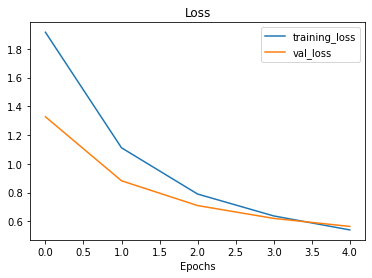

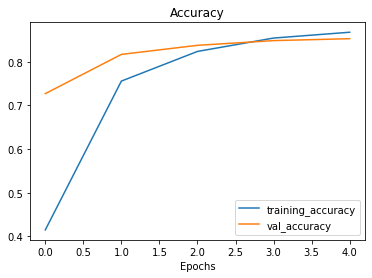

In [13]:
plot_loss_curves(history_0)

In [14]:
# Evaluate on full test data
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5640 - accuracy: 0.8532


[0.5640466809272766, 0.8532000184059143]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [17]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


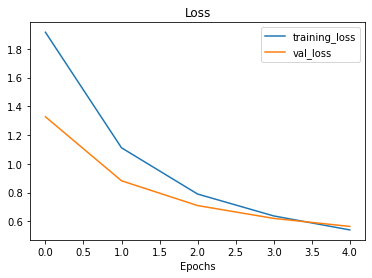

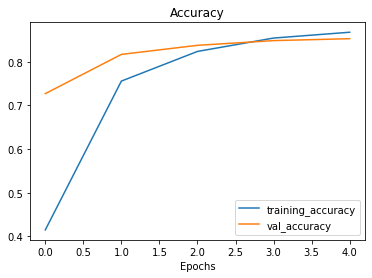

In [18]:
# Check put our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [21]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: [[[[ 0.65944386 -1.0235653  -0.32038543]
   [-0.78743905 -0.08868001 -0.9802929 ]
   [-0.15081745  0.2503116   1.5166535 ]
   [-0.6553093  -1.2945968   1.1228135 ]]

  [[-0.02056331  0.4377533   3.1819253 ]
   [ 0.0103294  -1.6611652   0.28415003]
   [-1.0769113   0.9202316  -0.7036925 ]
   [ 1.6281862   0.02959009 -1.6497234 ]]

  [[-1.9154358   0.9186649   0.5859192 ]
   [-1.8672508  -0.61618125 -1.1352825 ]
   [ 1.3185818  -0.96361417  0.05590763]
   [ 0.1730323  -0.40857017  0.25718263]]

  [[ 0.68236876  0.74550825 -0.29031083]
   [-0.10926438 -2.3506994  -0.04917658]
   [ 1.6521797   0.88095045  0.49832955]
   [-1.311312    1.0203433   0.10708926]]]]

2D Global average pooled random tensor:
 [[-0.11063632 -0.20023242  0.15506914]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [22]:
# Let's replicate the Global Average Pooled 2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.11063632, -0.20023242,  0.15506914]], dtype=float32)>

> ⚒️ **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about set  up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10%  of training data with augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset wil be used to evaluate our mode... this ensures consistency across evaluation metrics.



## Getting and preprocessing data for model_1

In [23]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-01-22 16:15:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.0MB/s    in 6.4s    

2023-01-22 16:15:17 (19.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [24]:
# Create train and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"



In [25]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [26]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32) # Default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our heads, after  reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation onlu happens during training, so we can still export our whole model and use it elsewhere.

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  #  preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#    preprocessing.Rescale(1.255) # Keep for models like ResNet50V2 but EfficientNet already preprocessed
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

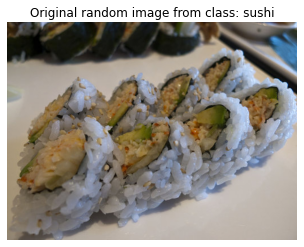

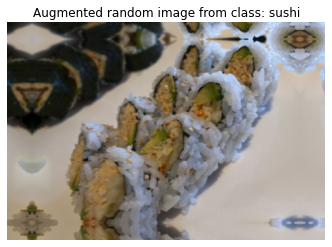

In [43]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_img = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_img

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature Eetraction transfer learning on 1% of the data with data augmentation

In [51]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=True)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=create_tensorboard_callback("tensorflow_hub", "1_percent_data_augmented"))

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_augmented/20230122-171809
Epoch 1/5
3/3 [==============================] - 13s 4s/step - loss: 2.2468 - accuracy: 0.1143 - val_loss: 2.1540 - val_accuracy: 0.2138
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0060 - accuracy: 0.2714 - val_loss: 2.0393 - val_accuracy: 0.2796
Epoch 3/5
3/3 [==============================] - 5s 3s/step - loss: 1.7747 - accuracy: 0.5143 - val_loss: 1.9240 - val_accuracy: 0.3898
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.6448 - accuracy: 0.6571 - val_loss: 1.8852 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.4978 - accuracy: 0.7000 - val_loss: 1.7681 - val_accuracy: 0.4589


In [53]:
# Check out a model summary
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [54]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 19s 226ms/step - loss: 1.7632 - accuracy: 0.4712


[1.7631515264511108, 0.47119998931884766]

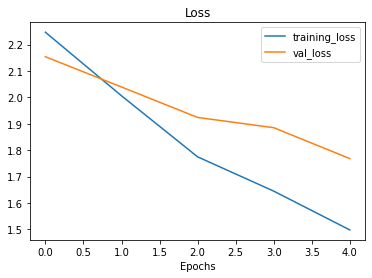

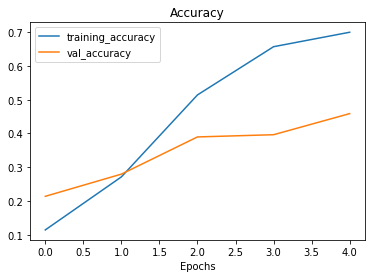

In [55]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation


In [56]:
# Get 10% of training data of 10 classes of food101 (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [58]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [60]:
# Create model_2 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
  #  preprocessing.Rescaling(1./255)
], name="data_augmentation")

In [61]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



### Creating a ModelCheckpoint callback

The ModeCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where left off.

In [66]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weight/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fot model 2 passing in the ModelCheckpoint callback

In [63]:
# Fot the model saving checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorflow_hub", "10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20230122-180724
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0034 - accuracy: 0.3347
Epoch 1: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 18s 531ms/step - loss: 2.0034 - accuracy: 0.3347 - val_loss: 1.4440 - val_accuracy: 0.6700
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.6800
Epoch 2: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 12s 483ms/step - loss: 1.3091 - accuracy: 0.6800 - val_loss: 0.9840 - val_accuracy: 0.7804
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.7613
Epoch 3: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 11s 453ms/step - loss: 1.0035 - accuracy: 0.7613 - val_loss: 0.7846 - val_accuracy: 0.8120
Epoch 4

In [64]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5640 - accuracy: 0.8532


[0.5640469193458557, 0.8532000184059143]

In [68]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 70ms/step - loss: 0.6157 - accuracy: 0.8424


[0.6156782507896423, 0.8424000144004822]

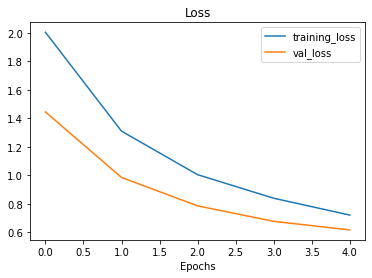

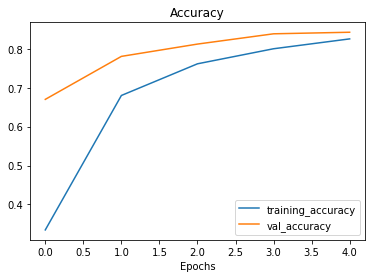

In [67]:
plot_loss_curves(history_2)

###  Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [70]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [71]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.6157 - accuracy: 0.8424


In [72]:
# If the results from our previously evaluated model_2 match the loaded weights, everything works/
results_10_percent_data_aug == loaded_weights_model_results

False

In [73]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [74]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]
